In [1017]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns

In [1018]:
pip install scikit-learn

26754.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1019]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

In [1020]:
df = pd.read_csv('/Users/liu/Desktop/kc_house_data.csv')

In [1021]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [1022]:
# Drop irrelevant columns
df = df.drop(['id', 'date'], axis=1)
df = df.dropna()  # Drop rows with missing values
df = df.drop_duplicates()

In [1023]:
# Feature engineering
df['age of house'] = 2023 - df['yr_built']  # Calculate age of the house


In [1024]:
# Create dummy variable for 'sqft_basement'
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
# Drop 'sqft_basement' column
df = df.drop('sqft_basement', axis=1)


In [1025]:
#fCreate dummy variable for 'yr_renovated'
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
# Drop 'yr_renovated' column
df = df.drop('yr_renovated', axis=1)

In [1026]:
#Create dummy variables
df = pd.get_dummies(df, columns=['waterfront', 'view','has_basement', 'renovated'], drop_first=True)

In [1027]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,sqft_living15,sqft_lot15,age of house,waterfront_1,view_1,view_2,view_3,view_4,has_basement_1,renovated_1
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,...,1340,5650,68,False,False,False,False,False,False,False
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,...,1690,7639,72,False,False,False,False,False,True,True
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,...,2720,8062,90,False,False,False,False,False,False,False
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,...,1360,5000,58,False,False,False,False,False,True,False
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,...,1800,7503,36,False,False,False,False,False,False,False


In [1028]:
# Split the data into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = df['price']

In [1029]:
# Correlation analysis
correlation = df.corr()['price'].abs().sort_values(ascending=False)
top_features = correlation[correlation > 0.5].index.tolist()

In [1030]:
# Print the selected features
print("Top Features based on correlation analysis:")
print(top_features)

Top Features based on correlation analysis:
['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']


In [1031]:
from sklearn.feature_selection import SelectKBest, f_regression

In [1032]:
# Recursive Feature Elimination (RFE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

estimator = LinearRegression()
selector = SelectKBest(score_func=f_regression, k=5)
X_rfe = selector.fit_transform(X_scaled, y)
mask = selector.get_support()

selected_features_rfe = X.columns[mask]

print("\nTop Features selected using RFE:")
print(selected_features_rfe)


Top Features selected using RFE:
Index(['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15'], dtype='object')


With these two method I choose 'sqft_living', 'grade','sqft_above' and 'bathrooms' as features.

In [1033]:
results = ols("price ~ sqft_living + grade + sqft_above + bathrooms", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     6432.
Date:                Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:04:31   Log-Likelihood:            -2.9906e+05
No. Observations:               21608   AIC:                         5.981e+05
Df Residuals:                   21603   BIC:                         5.982e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.506e+05   1.35e+04    -48.137      

In [1034]:
"y_hat = -6.506e+05 + 252.4888sqft_living +1.151e+05grade -76.9262sqft_above -3.726e+04bathrooms "

'y_hat = -6.506e+05 + 252.4888sqft_living +1.151e+05grade -76.9262sqft_above -3.726e+04bathrooms '

As from the OLS we can see here are strong multicollinearity we need to mitigate multicollinearity 

In [1035]:
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_grade'] = np.log(df['grade'])
df['log_sqft_above'] = np.log(df['sqft_above'])
df['log_price'] = np.log(df['price'])


In [1036]:
results = ols("log_price ~ log_sqft_living + log_grade + log_sqft_above + bathrooms", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     6399.
Date:                Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:04:31   Log-Likelihood:                -8363.6
No. Observations:               21608   AIC:                         1.674e+04
Df Residuals:                   21603   BIC:                         1.678e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.8149      0.061    1

In [1037]:
pred_vals = results.predict(df[['log_sqft_living', 'log_grade','log_sqft_above','bathrooms']])

In [1038]:
pred_vals

0        12.707258
1        13.041477
2        12.292300
3        13.025259
4        13.057698
           ...    
21608    13.019945
21609    13.180565
21610    12.651094
21611    13.037387
21612    12.651094
Length: 21608, dtype: float64

In [1039]:
res = pd.concat([pred_vals.to_frame().rename(columns={0:'y_hat'}),df['price']], axis=1)

In [1040]:
res

,y_hat,price
0,12.707258,221900.0
1,13.041477,538000.0
2,12.292300,180000.0
3,13.025259,604000.0
4,13.057698,510000.0
...,...,...
21608,13.019945,360000.0
21609,13.180565,400000.0
21610,12.651094,402101.0
21611,13.037387,400000.0


In [1041]:
res['log_price']= df['log_price']

In [1042]:
res['error'] = res['y_hat'] - res['log_price']

In [1043]:
res.head(1)

,y_hat,price,log_price,error
0,12.707258,221900.0,12.309982,0.397276


In [1044]:
res['sq_error'] = res['error']**2

In [1045]:
np.sqrt(res['sq_error'].mean())

0.35633786688370933

In [1046]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,age of house,log_sqft_living,log_grade,log_sqft_above,log_price
count,2.160800e+04,21608.000000,21608.000000,21608.000000,2.160800e+04,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000
mean,5.400984e+05,3.370927,2.114738,2079.958950,1.510962e+04,1.494146,3.409478,7.656655,1788.414846,1970.999907,98077.942614,47.560050,-122.213894,1986.583164,12770.108340,52.000093,7.550355,2.024191,7.394887,13.047811
std,3.671646e+05,0.930103,0.770238,918.505805,4.142491e+04,0.539910,0.650782,1.175484,828.141155,29.371463,53.506883,0.138578,0.140830,685.421474,27307.006892,29.371463,0.424828,0.150356,0.427632,0.526725
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,1.000000,290.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,8.000000,5.669881,0.000000,5.669881,11.225243
25%,3.218375e+05,3.000000,1.750000,1429.250000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.470875,-122.328000,1490.000000,5100.000000,26.000000,7.264905,1.945910,7.081709,12.681802
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.230500,1840.000000,7620.000000,48.000000,7.554859,1.945910,7.352441,13.017003
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.250000,72.000000,7.843849,2.079442,7.700748,13.377006
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,123.000000,9.513404,2.564949,9.149528,15.856731


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.800e+01, 2.880e+02, 1.887e+03,
        7.306e+03, 8.284e+03, 3.576e+03, 2.480e+02]),
 array([-2.83818534, -2.44004063, -2.04189591, -1.64375119, -1.24560647,
        -0.84746175, -0.44931703, -0.05117231,  0.34697241,  0.74511713,
         1.14326185]),
 <BarContainer object of 10 artists>)

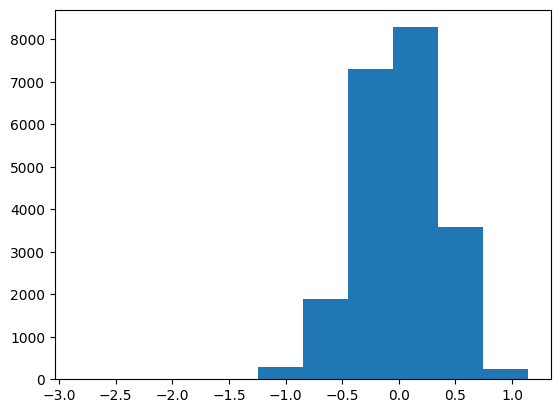

In [1047]:
plt.hist(res['error'])

(array([6.300e+01, 5.330e+02, 3.976e+03, 7.183e+03, 6.341e+03, 2.541e+03,
        7.330e+02, 1.930e+02, 3.800e+01, 7.000e+00]),
 array([11.22524339, 11.68839214, 12.15154089, 12.61468964, 13.07783839,
        13.54098714, 14.00413589, 14.46728464, 14.93043339, 15.39358214,
        15.85673089]),
 <BarContainer object of 10 artists>)

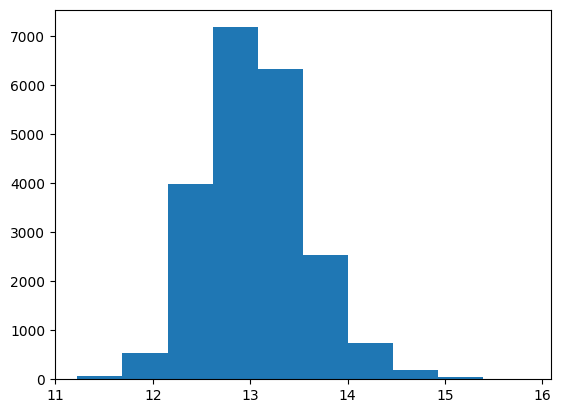

In [1048]:
plt.hist(df['log_price'])

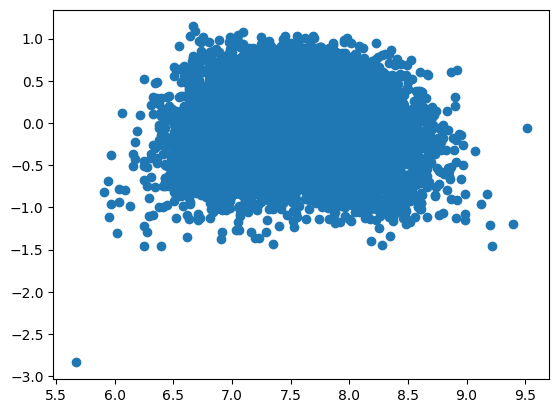

In [1049]:
plt.scatter(df['log_sqft_living'],res['error'])

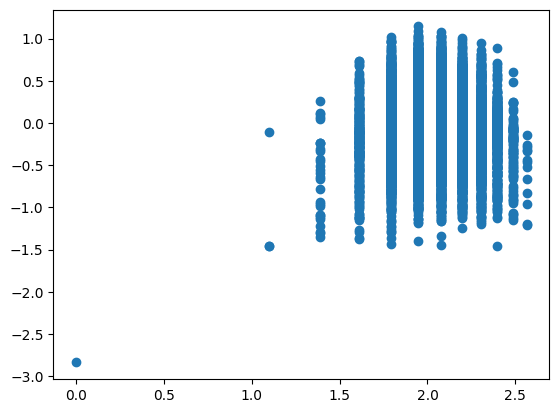

In [1050]:
plt.scatter(df['log_grade'],res['error'])

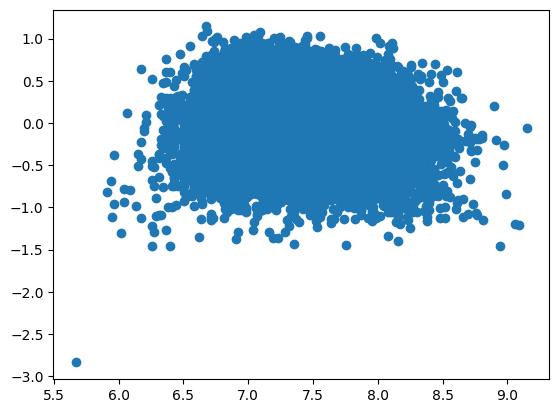

In [1051]:
plt.scatter(df['log_sqft_above'],res['error'])

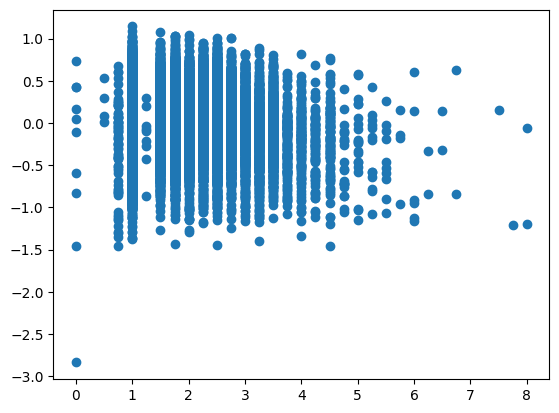

In [1052]:
plt.scatter(df['bathrooms'],res['error'])

((array([-3.99698079, -3.78175478, -3.66402403, ...,  3.66402403,
          3.78175478,  3.99698079]),
  array([-2.83818534, -1.46245135, -1.45482086, ...,  1.07840931,
          1.09409875,  1.14326185])),
 (0.3557112629035258, -6.879416887558399e-15, 0.9980638172464935))

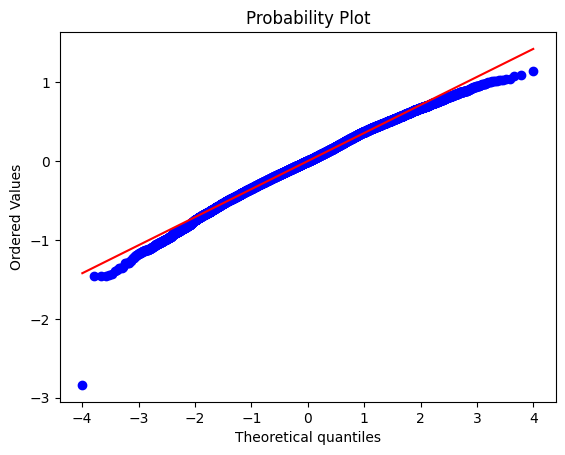

In [1053]:
import scipy.stats as stats
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res['error'], dist='norm', plot=ax)

In [1054]:
infl = results.get_influence()
print(infl.summary_frame())

       dfb_Intercept  dfb_log_sqft_living  dfb_log_grade  dfb_log_sqft_above   
0          -0.000329             0.003961      -0.004317           -0.002834  \
1          -0.002059             0.002351      -0.004666            0.001748   
2          -0.006176             0.004286       0.000167           -0.000584   
3           0.009372             0.005298      -0.003626           -0.011536   
4           0.000152            -0.001272       0.001173            0.000689   
...              ...                  ...            ...                 ...   
21608      -0.004858             0.006041      -0.003210           -0.001003   
21609       0.001555             0.002419       0.001281           -0.004595   
21610       0.000914            -0.003194       0.004934            0.000870   
21611      -0.002563             0.003420      -0.001680           -0.000791   
21612       0.000146            -0.000510       0.000788            0.000139   

       dfb_bathrooms       cooks_d  sta

In [1055]:
infl.summary_frame()

,dfb_Intercept,dfb_log_sqft_living,dfb_log_grade,dfb_log_sqft_above,dfb_bathrooms,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.000329,0.003961,-0.004317,-0.002834,0.008062,4.274466e-05,-1.114852,0.000172,-0.014619,-1.114859,-0.014619
1,-0.002059,0.002351,-0.004666,0.001748,-0.000730,7.561872e-06,0.432552,0.000202,0.006149,0.432544,0.006149
2,-0.006176,0.004286,0.000167,-0.000584,-0.000922,1.505318e-05,-0.537665,0.000260,-0.008676,-0.537656,-0.008675
3,0.009372,0.005298,-0.003626,-0.011536,0.011124,5.923020e-05,0.802900,0.000459,0.017209,0.802893,0.017209
4,0.000152,-0.001272,0.001173,0.000689,-0.000172,1.060696e-06,0.237027,0.000094,0.002303,0.237022,0.002303
...,...,...,...,...,...,...,...,...,...,...,...
21608,-0.004858,0.006041,-0.003210,-0.001003,-0.004912,1.451796e-05,-0.634454,0.000180,-0.008520,-0.634446,-0.008520
21609,0.001555,0.002419,0.001281,-0.004595,-0.000997,1.151914e-05,-0.789491,0.000092,-0.007589,-0.789484,-0.007589
21610,0.000914,-0.003194,0.004934,0.000870,-0.006000,2.541364e-05,0.711031,0.000251,0.011272,0.711023,0.011272
21611,-0.002563,0.003420,-0.001680,-0.000791,-0.002729,4.684281e-06,-0.387726,0.000156,-0.004840,-0.387718,-0.004839


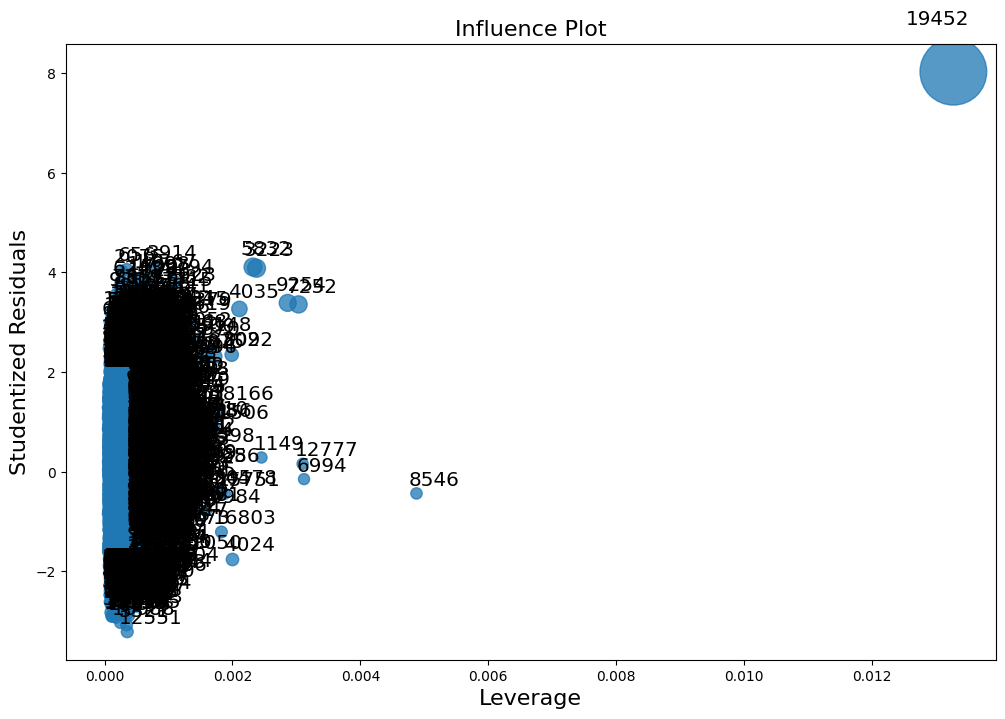

In [1056]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, ax=ax, criterion='cooks')

In [1057]:
filtered_df = df.drop(19452,axis=0)

In [1058]:
results_log_drop = ols("log_price ~ log_sqft_living + log_grade + log_sqft_above + bathrooms", data=filtered_df).fit()

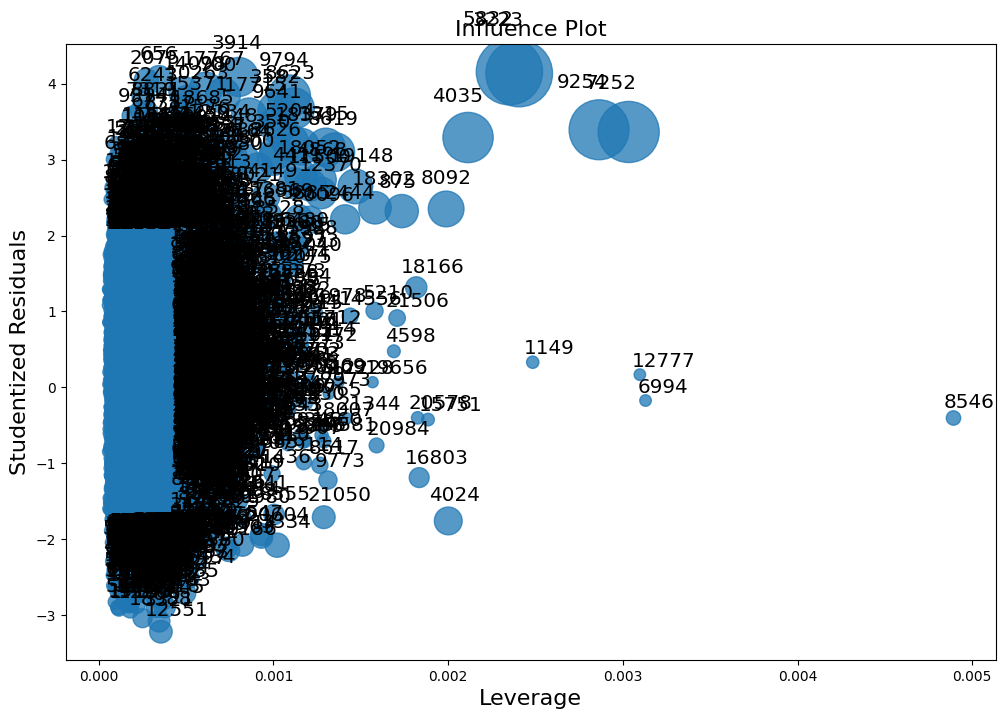

In [1059]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results_log_drop , ax=ax, criterion='cooks')

In [1060]:
res

,y_hat,price,log_price,error,sq_error
0,12.707258,221900.0,12.309982,0.397276,0.157828
1,13.041477,538000.0,13.195614,-0.154137,0.023758
2,12.292300,180000.0,12.100712,0.191588,0.036706
3,13.025259,604000.0,13.311329,-0.286071,0.081837
4,13.057698,510000.0,13.142166,-0.084468,0.007135
...,...,...,...,...,...
21608,13.019945,360000.0,12.793859,0.226086,0.051115
21609,13.180565,400000.0,12.899220,0.281345,0.079155
21610,12.651094,402101.0,12.904459,-0.253365,0.064194
21611,13.037387,400000.0,12.899220,0.138167,0.019090


In [1061]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,age of house,log_sqft_living,log_grade,log_sqft_above,log_price
count,2.160800e+04,21608.000000,21608.000000,21608.000000,2.160800e+04,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000,21608.000000
mean,5.400984e+05,3.370927,2.114738,2079.958950,1.510962e+04,1.494146,3.409478,7.656655,1788.414846,1970.999907,98077.942614,47.560050,-122.213894,1986.583164,12770.108340,52.000093,7.550355,2.024191,7.394887,13.047811
std,3.671646e+05,0.930103,0.770238,918.505805,4.142491e+04,0.539910,0.650782,1.175484,828.141155,29.371463,53.506883,0.138578,0.140830,685.421474,27307.006892,29.371463,0.424828,0.150356,0.427632,0.526725
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,1.000000,290.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,8.000000,5.669881,0.000000,5.669881,11.225243
25%,3.218375e+05,3.000000,1.750000,1429.250000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.470875,-122.328000,1490.000000,5100.000000,26.000000,7.264905,1.945910,7.081709,12.681802
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.230500,1840.000000,7620.000000,48.000000,7.554859,1.945910,7.352441,13.017003
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.250000,72.000000,7.843849,2.079442,7.700748,13.377006
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,123.000000,9.513404,2.564949,9.149528,15.856731


In [1062]:
df.info(all)

<class 'pandas.core.frame.DataFrame'>
Index: 21608 entries, 0 to 21612
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21608 non-null  float64
 1   bedrooms         21608 non-null  int64  
 2   bathrooms        21608 non-null  float64
 3   sqft_living      21608 non-null  int64  
 4   sqft_lot         21608 non-null  int64  
 5   floors           21608 non-null  float64
 6   condition        21608 non-null  int64  
 7   grade            21608 non-null  int64  
 8   sqft_above       21608 non-null  int64  
 9   yr_built         21608 non-null  int64  
 10  zipcode          21608 non-null  int64  
 11  lat              21608 non-null  float64
 12  long             21608 non-null  float64
 13  sqft_living15    21608 non-null  int64  
 14  sqft_lot15       21608 non-null  int64  
 15  age of house     21608 non-null  int64  
 16  waterfront_1     21608 non-null  bool   
 17  view_1           

In [1063]:
# separate features and target
categorical_features = ['waterfront_1','view_1','view_2','view_3','view_4','has_basement_1','renovated_1']
numerical_features = ['log_sqft_living', 'log_grade','log_sqft_above','bathrooms']
target = 'log_price'

In [1064]:
# split data in train / test
# split data in train / test
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numerical_features]
                                                    ,df[target],
                                                    test_size = 0.3, random_state=1234)

In [1065]:
# define transformers
cat_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps = [('scaler', StandardScaler())])

In [1066]:
# building processor
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, categorical_features),
                                                 ('num', num_transformer, numerical_features)])

In [1067]:
linear_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [1068]:
linear_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['waterfront_1', 'view_1',
                                                   'view_2', 'view_3', 'view_4',
                                                   'has_basement_1',
                                                   'renovated_1']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_grade',
                                                   'log_sqft_above',
                                                   'bathrooms'])])),
                ('regressor', LinearRegression())])

In [1069]:
pred = linear_regression.predict(X_test)

In [1070]:
pred

array([13.13769531, 12.75488281, 12.29980469, ..., 12.91796875,
       12.57617188, 13.37890625])

In [1071]:
from sklearn.metrics import mean_squared_error

In [1072]:
np.sqrt(mean_squared_error(pred,y_test))

0.33620505859256855

In [1073]:
ridge_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=3.0))
])

In [1074]:
ridge_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['waterfront_1', 'view_1',
                                                   'view_2', 'view_3', 'view_4',
                                                   'has_basement_1',
                                                   'renovated_1']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_grade',
                                                   'log_sqft_above',
                                                   'bathrooms'])])),
                ('regressor', Ridge(alpha=3.0))])

In [1075]:
pred_ridge = ridge_regression.predict(X_test)

In [1076]:
np.sqrt(mean_squared_error(pred_ridge,y_test))

0.3360612017386579

In [1077]:
lasso_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))
])

In [1078]:
lasso_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['waterfront_1', 'view_1',
                                                   'view_2', 'view_3', 'view_4',
                                                   'has_basement_1',
                                                   'renovated_1']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_grade',
                                                   'log_sqft_above',
                                                   'bathrooms'])])),
                ('regressor', Lasso())])

In [1079]:
lasso_pred = lasso_regression.predict(X_test)

In [1080]:
np.sqrt(mean_squared_error(lasso_pred, y_test))

0.5259164250510572

In [1081]:
elasticnet_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.8))
])

In [1082]:
elasticnet_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['waterfront_1', 'view_1',
                                                   'view_2', 'view_3', 'view_4',
                                                   'has_basement_1',
                                                   'renovated_1']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_sqft_living',
                                                   'log_grade',
                                                   'log_sqft_above',
                                                   'bathrooms'])])),
                ('regressor', ElasticNet(l1_ratio=0.8))])

In [1083]:
elasticnet_pred = elasticnet_regression.predict(X_test)

In [1084]:
np.sqrt(mean_squared_error(elasticnet_pred, y_test))

0.5259164250510572